In [43]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from langchain_google_genai import ChatGoogleGenerativeAI
from asset.Model import classify_text
from asset.Visualize import get_n_colors_from_plotly_scale
import os
named_colorscales = px.colors.named_colorscales()

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './cert/cdp-rd-vertex-ai.json'

In [16]:
data = load_dataset("community-datasets/disaster_response_messages",split="train")
data_df = data.to_pandas().sample(2000)

In [17]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
all_emb = []
for i in tqdm(range(0,len(data_df),10)):
    all_emb.append(model.encode(data_df['message'].values[i:i+10].tolist()))

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
sentence_embeddings = np.concatenate(all_emb,axis=0)
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(sentence_embeddings)


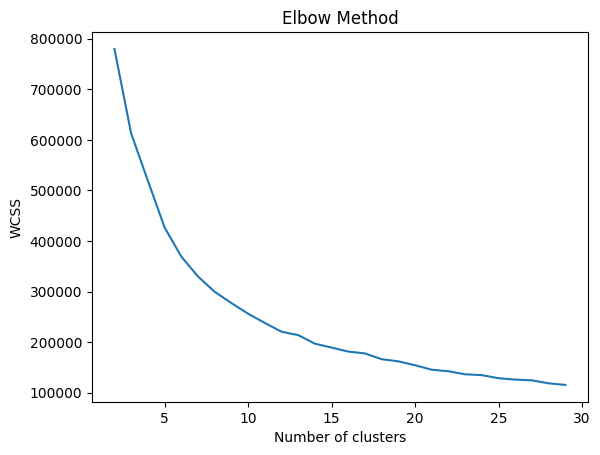

In [30]:
# WCSS代表群內平方和
# 計算每一群中的每一個資料點到群中心的距離
wcss = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(tsne_results)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 30), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()


In [32]:
n_cluster = 15
k_means = KMeans(n_clusters=n_cluster,init='k-means++').fit(tsne_results)
k_means_results = k_means.predict(tsne_results)

data_df[['t0','t1','t2']] = tsne_results
data_df['cluster'] = k_means_results


In [40]:
chat_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17",temperature=0)

msg_clf = {}
for id,df in data_df.groupby('cluster'):
    ai_msg = classify_text(df['message'].to_string())
    msg_clf[id] = ai_msg
    
print(msg_clf)

{0: '关于地震及相关自然灾害的咨询', 1: '各地冲突、灾害、政治及人道状况', 2: '大量非游戏类求助咨询。', 3: '询问灾后帐篷、食物、水和住所', 4: '客户询问信息、回复及无关留言', 5: '这些问题主要关于自然灾害、农业、粮食安全与环境。', 6: '关于天气、灾害及预报的问题', 7: '海地智利地震相关询问', 8: '询问风暴影响、停电及安全状况', 9: '寻求食物、工作、住所、援助信息', 10: '这些问题总结为：**灾情求助与救援进展**', 11: '这些问题主要关于灾区援助、健康与饮水需求。', 12: '这些问题总结为：援助行动、团队、设备与当地情况。', 13: '您好，这些消息似乎是寻求食物、水及援助信息，与游戏平台无关。', 14: '人道援助、健康危机与救援行动'}


In [41]:
data_df['cluster_name'] = data_df['cluster'].apply(lambda c:msg_clf[c])
data_df['cluster_name'] = data_df['cluster_name'].apply(lambda s: '-'.join(list(set(s.split('\n')))))

In [42]:
data_df

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,fire,earthquake,cold,other_weather,direct_report,t0,t1,t2,cluster,cluster_name
15887,train,U.S. Senate majority leader Harry Reid has all...,,news,0,0,0,0,0,0,...,0,0,0,0,0,11.130377,-26.381191,3.332763,11,这些问题主要关于灾区援助、健康与饮水需求。
9673,train,rinaVG Hi Sweetie! Miss u to! Got stock in San...,,social,0,0,0,0,0,0,...,0,0,0,0,0,-1.945798,32.453804,12.361233,7,海地智利地震相关询问
10713,train,Many times catastrophic flood causing huge san...,,news,1,0,0,0,1,0,...,0,0,0,0,0,-10.534164,-23.210213,3.396156,5,这些问题主要关于自然灾害、农业、粮食安全与环境。
11927,train,Grains and soyabeans from eastern India destin...,,news,0,0,0,0,0,0,...,0,0,0,0,0,-20.103764,-24.589912,-4.522260,5,这些问题主要关于自然灾害、农业、粮食安全与环境。
20157,train,"ROC distributes food, hygiene kits, clothes an...",,news,1,0,0,0,1,0,...,0,0,0,0,0,8.243124,-8.900224,-14.115572,9,寻求食物、工作、住所、援助信息
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,train,information for work in the country,Information pour travail dans le payi,direct,0,0,0,0,0,0,...,0,0,0,0,0,4.331253,10.581864,-26.706453,9,寻求食物、工作、住所、援助信息
8198,train,RT cnnbrk Hillary Clinton speaks on providing ...,,social,1,0,0,0,0,0,...,0,0,1,0,1,-13.178160,19.568214,11.953656,7,海地智利地震相关询问
14920,train,World Vision has called on all those involved ...,,news,1,0,0,0,0,0,...,0,0,0,0,0,-12.063879,8.741318,-4.067389,12,这些问题总结为：援助行动、团队、设备与当地情况。
10198,train,"5th ave in a hurricane = deal, NJ on a normal ...",,social,1,0,0,0,0,0,...,0,0,0,0,1,15.569403,10.661863,17.913025,8,询问风暴影响、停电及安全状况


In [44]:
n_cluster = data_df['cluster'].nunique()
category_colors = get_n_colors_from_plotly_scale(n_cluster, scale_name='Plotly')

fig = go.Figure()
for color,(c,df) in enumerate(data_df.groupby('cluster')):
    fig.add_trace(go.Scatter3d(
        x=df['t0'],
        y=df['t1'],
        z=df['t2'],
        mode='markers',
        text=df['message'],
        textposition="middle center",
         marker=dict(
            size=8,
            color=category_colors[c],  # 每個類別使用單一顏色
            symbol='circle',
            opacity=0.75,
        ),
        name=df['cluster_name'].astype(str).values[0],
        showlegend=True,
        hovertemplate='<b>%{text} </b><br>' +
                      'X: %{x:.2f}<br>' +
                      'Y: %{y:.2f}<br>' +
                      'Z: %{z:.2f}<extra></extra>'
    ))
    center_text = '[中心點]' + df['cluster_name'].astype(str).values[0] 
    fig.add_trace(
        go.Scatter3d(
            x=[k_means.cluster_centers_[c,0]],
            y=[k_means.cluster_centers_[c,1]],
            z=[k_means.cluster_centers_[c,2]],
            mode='markers',
            marker=dict(
                size=10,
                color=category_colors[c],
                symbol='cross',
                opacity=1
        ),
        name=center_text,
        text=center_text,
        # hovertemplate='<b>%{text}</b><br>' +
        #               'X: %{x:.2f}<br>' +
        #               'Y: %{y:.2f}<br>' +
        #               'Z: %{z:.2f}<extra></extra>',
        showlegend=False
        )
    )


# 更新佈局，調整圖例位置
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='對話分群(sampling 2000 points.)',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=1.02,  # 將圖例放在圖的右側 (1.0 代表最右邊)
        y=1,     # 將圖例放在圖的頂部 (1.0 代表最頂部)
        xanchor="left", # 圖例的水平錨點為左側
        yanchor="top",  # 圖例的垂直錨點為頂部
        bgcolor="rgba(255, 255, 255, 0.5)", # 背景顏色 (半透明白色)
        bordercolor="Black",
        borderwidth=1
    )
)

fig.write_html("./cluster.html")